# Model Selecton and Experimentation

In this notebook, I try different models to predict the property prices based on my curated dataset.

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [37]:
final_features = pd.read_pickle(r"C:\Users\Roydon\Desktop\Property Price Project\Final Project Code\Data\final_features.pkl")
final_features

,num_area,lease_left,float_x,float_y,num_price,floor_range,year_transacted,property_type
0,524.3,999.0,22734.925781,29502.419922,5500000,0.0,3.0,7.0
1,308.0,999.0,22734.925781,29502.419922,5000000,0.0,1.0,7.0
2,314.0,999.0,22734.925781,29502.419922,4750000,0.0,1.0,7.0
3,308.0,999.0,22734.925781,29502.419922,5200000,0.0,4.0,7.0
4,257.0,999.0,20914.199219,30589.107422,4600000,0.0,5.0,6.0
...,...,...,...,...,...,...,...,...
131733,304.1,999.0,27055.871094,45402.906250,3430000,0.0,5.0,6.0
131734,268.2,999.0,27055.871094,45402.906250,2480000,0.0,0.0,6.0
131735,215.0,999.0,27055.871094,45402.906250,1100000,0.0,2.0,1.0
131736,295.3,999.0,27055.871094,45402.906250,3400000,0.0,4.0,6.0


In [38]:
from sklearn.model_selection import train_test_split

# Split data into training and validation data, for both features and target
y = final_features["num_price"]
X = final_features[["num_area", "floor_range", "property_type", "lease_left", "float_x", "float_y"]]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)

### Random Forest Regressor Implementation (Vs dummy)

Here I implement a dummy regressor that outputs the mean for all predictions, as a benchmark model to compare my subsequent models with. I will compare the Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RMSE). First, I compare it with Random Forest Regressor.

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Dummy Model (mean)
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(train_X, train_y)
data_pred = dummy_regr.predict(val_X)

print("Mean Absolute Error (Dummy): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Dummy): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Dummy): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Random Forest Regressor
rand_forest = RandomForestRegressor(random_state=1)
rand_forest.fit(train_X, train_y)
data_pred = rand_forest.predict(val_X)

# Printing Accuracy of Model
print("Mean Absolute Error (Rand_forest): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Rand_forest): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Rand_forest): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Dummy): 1024629.4251960467
Mean Squared Error (Dummy): 5285973826681.23
Root Mean Squared Error (Dummy): 2299124.5783300283


Mean Absolute Error (Rand_forest): 136069.14068470805
Mean Squared Error (Rand_forest): 543651039384.3351
Root Mean Squared Error (Rand_forest): 737326.9555525114


The random forest regressor performed significantly better than the dummy.

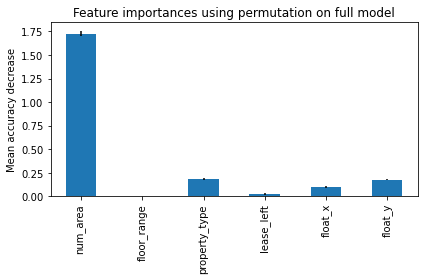

In [40]:
from sklearn.inspection import permutation_importance

# Calculating Feature Importance
result = permutation_importance(rand_forest, val_X, val_y)
feature_names = ["num_area", "floor_range", "property_type", "lease_left", "float_x", "float_y"]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Plotting Graph
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

As seen from the above plot, the random forest model uses floor area of the property as the most significant deciding factor of price for this model, and the other features do not appear significant in the prediction process.

The current data and features available may not be generalizing well for freehold and landed properties. I believe with the current dataset, I may be able to give more accurate predictions with non-landed properties, with lease period within 100 years. For these properties, the other features may have a greater significance and model may be less skewed by outlier cases.

I hence decided to try experimenting the process on a subset of the dataset to see if prediction performance improves. The subset I chose this time only Strata property types, with lease period less than 100 yrs.

## Testing with subset of dataset

In [41]:
# Prepare subset of dataset (non-landed, lease within 100 yrs)
datasetWithoutLanded_df = final_features.copy()
outlier_index = datasetWithoutLanded_df[(datasetWithoutLanded_df.lease_left > 101) | 
                                        (datasetWithoutLanded_df.property_type > 5)].index
datasetWithoutLanded_df.drop(outlier_index, axis=0, inplace=True)
datasetWithoutLanded_df = datasetWithoutLanded_df.reset_index()

# New train-test split
y2 = datasetWithoutLanded_df["num_price"]
X2 = datasetWithoutLanded_df[["num_area", "floor_range", "property_type", "lease_left", "float_x", "float_y"]]
train_X, val_X, train_y, val_y = train_test_split(X2, y2,random_state = 0)

# Dummy Model (mean)
dummy_regr2 = DummyRegressor(strategy="mean")
dummy_regr2.fit(train_X, train_y)
data_pred = dummy_regr2.predict(val_X)

print("Mean Absolute Error (Dummy): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Dummy): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Dummy): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Random Forest Regressor
rand_forest_2 = RandomForestRegressor(random_state=1)
rand_forest_2.fit(train_X, train_y)
data_pred = rand_forest_2.predict(val_X)

print("Mean Absolute Error (Rand_forest): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Rand_forest): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Rand_forest): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Dummy): 458614.5654738787
Mean Squared Error (Dummy): 540363704185.5847
Root Mean Squared Error (Dummy): 735094.3505330351


Mean Absolute Error (Rand_forest): 49871.847780550044
Mean Squared Error (Rand_forest): 16829354800.467407
Root Mean Squared Error (Rand_forest): 129728.00314684339


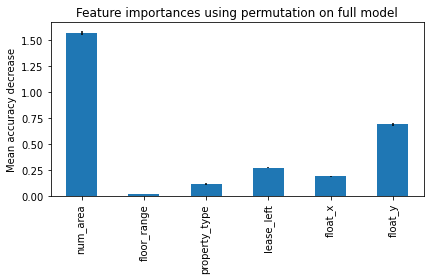

In [42]:
# Calculating Feature Importance
result = permutation_importance(rand_forest_2, val_X, val_y)
feature_names = ["num_area", "floor_range", "property_type", "lease_left", "float_x", "float_y"]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Plotting Graph
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Significant improvement in the both models can be seen for both the dummy and the random forest model.

The coordinates ('float_x' and 'float_y') and 'lease_left' features were used more in the prediction process, while property type reduced importance as a feature. In this case the random forest model could utilize other features provided more, and beat the dummy model signifacntly.

I proceeded to build a model with only landed property data, to observe if a similar improvement happens.

In [43]:
datasetWithoutStrata_df = final_features.copy()
outlier_index = datasetWithoutStrata_df[(datasetWithoutStrata_df.property_type < 6)].index
datasetWithoutStrata_df.drop(outlier_index, axis=0, inplace=True)
datasetWithoutStrata_df = datasetWithoutStrata_df.reset_index()

# Training the model
y3 = datasetWithoutStrata_df["num_price"]
X3 = datasetWithoutStrata_df[["num_area", "floor_range", "property_type", "lease_left", "float_x", "float_y"]]
train_X, val_X, train_y, val_y = train_test_split(X3, y3,random_state = 0)

# Dummy Model (mean)
dummy_regr3 = DummyRegressor(strategy="mean")
dummy_regr3.fit(train_X, train_y)
data_pred = dummy_regr3.predict(val_X)

print("Mean Absolute Error (Dummy): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Dummy): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Dummy): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Random Forest Regressor
rand_forest_3 = RandomForestRegressor(random_state=1)
rand_forest_3.fit(train_X, train_y)
data_pred = rand_forest_3.predict(val_X)

print("Mean Absolute Error (Rand_forest): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Rand_forest): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Rand_forest): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Dummy): 2416619.540169195
Mean Squared Error (Dummy): 24228538409419.74
Root Mean Squared Error (Dummy): 4922249.324182973


Mean Absolute Error (Rand_forest): 589786.789155781
Mean Squared Error (Rand_forest): 3207750844570.861
Root Mean Squared Error (Rand_forest): 1791019.49865736


As seen above, while the model trained with the given features did significantly better than the dummy, it was not robust enough to accurately predict prices for landed properties, performing even more poorly than the model trained with the whole dataset. This may be because freehold property prices are affected more greatly by other factors (age of property, current state of the property etc.) which were not accounted for.

## Model Selection (Performance of other types of regressor models)

From here onwards, I decided to pivot my project to only predict prices for non-landed properties within the 100 year lease period.

In the final cell below, I tested a few other types of models to compare against the tree based model, Random Forest. 
- Ridge Regression:  to test parametric models.
- Multi-layer Perceptron Regressor: to test deep learning models. (Tweaked the learning rate and max-iteration for this, since default learning rate could not converge with the default number of iterations)

In [44]:
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor

# Reset train-test split to subset of dataset
train_X, val_X, train_y, val_y = train_test_split(X2, y2,random_state = 0)

# Multi-variable Linear Regression
linear_reg = linear_model.Ridge(alpha=.5)
linear_reg.fit(train_X, train_y)
data_pred = linear_reg.predict(val_X)

print("Mean Absolute Error (Ridge_reg): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Ridge_reg): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Ridge_reg): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Neural Network (Multi-layer Perceptron Regressor) (1 layer, 10 nodes)
neural_network_reg = MLPRegressor(hidden_layer_sizes=(10,), random_state=1, solver='adam', max_iter=500, learning_rate_init= 0.01)
neural_network_reg.fit(train_X, train_y)
data_pred = neural_network_reg.predict(val_X)

print("Mean Absolute Error (Neural_network_reg_1): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Neural_network_reg_1): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Neural_network_reg_1): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Neural Network (Multi-layer Perceptron Regressor) (1 layer, 50 nodes)
neural_network_reg = MLPRegressor(hidden_layer_sizes=(50,), random_state=1, solver='adam', max_iter=500, learning_rate_init= 0.01)
neural_network_reg.fit(train_X, train_y)
data_pred = neural_network_reg.predict(val_X)

print("Mean Absolute Error (Neural_network_reg_2): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Neural_network_reg_2): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Neural_network_reg_2): {}".format((mean_squared_error(val_y, data_pred)**0.5)))
print("\n")

# Neural Network (Multi-layer Perceptron Regressor) (2 layer, 10 nodes each)
neural_network_reg = MLPRegressor(hidden_layer_sizes=(10, 10), random_state=1, solver='adam', max_iter=500, learning_rate_init= 0.01)
neural_network_reg.fit(train_X, train_y)
data_pred = neural_network_reg.predict(val_X)

print("Mean Absolute Error (Neural_network_reg_3): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (Neural_network_reg_3): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (Neural_network_reg_3): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (Ridge_reg): 258862.87428600076
Mean Squared Error (Ridge_reg): 193632460479.98065
Root Mean Squared Error (Ridge_reg): 440036.8853630121


Mean Absolute Error (Neural_network_reg_1): 231331.63685004736
Mean Squared Error (Neural_network_reg_1): 161926210867.2145
Root Mean Squared Error (Neural_network_reg_1): 402400.5602222921


Mean Absolute Error (Neural_network_reg_2): 247520.2001786466
Mean Squared Error (Neural_network_reg_2): 169930755646.27945
Root Mean Squared Error (Neural_network_reg_2): 412226.58289620216


Mean Absolute Error (Neural_network_reg_3): 221625.18080856014
Mean Squared Error (Neural_network_reg_3): 137403193027.27434
Root Mean Squared Error (Neural_network_reg_3): 370679.36687557126


Compared to random forest regressor:

- Mean Absolute Error (Rand_forest): 49871.847780550044
- Mean Squared Error (Rand_forest): 16829354800.467407
- Root Mean Squared Error (Rand_forest): 129728.00314684339

Without any hyperparameter tuning, tree based model seem to outperformed other types of models significantly. Adding more nodes of the Neural Network model appears to reduce model accuracy, while increasing the number of layers improved accuracy slightly, but its performance it is still far from the accuracy of the Random Forest model.

With this in consideration, I decided to compare Random Forest to another tree-based model, XGBoost, to see which performs better.

## Comparing Tree Based Models (XGBoost Vs Random Forest)

In [45]:
import xgboost as xg

xgb_reg = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 10, seed = 123)
xgb_reg.fit(train_X, train_y)
data_pred = xgb_reg.predict(val_X)

print("Mean Absolute Error (XGBoost_Reg): {}".format(mean_absolute_error(val_y, data_pred)))
print("Mean Squared Error (XGBoost_Reg): {}".format(mean_squared_error(val_y, data_pred)))
print("Root Mean Squared Error (XGBoost_Reg): {}".format((mean_squared_error(val_y, data_pred)**0.5)))

Mean Absolute Error (XGBoost_Reg): 138099.23572558395
Mean Squared Error (XGBoost_Reg): 53482020168.27897
Root Mean Squared Error (XGBoost_Reg): 231261.80006278376


XGBoost perfromed better than Linear and Neural Network methods as well, but still did not beat Random Forest Model. Hence, I decided to go with the Random Forest model.

In [46]:
import pickle

# Saving best model to pickle
pickle.dump(rand_forest_2, open('best_model.pkl', 'wb'))